Import Libaries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [41]:
import tensorflow

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, RepeatVector, TimeDistributed 
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau

Load The Data

In [12]:
df =web.DataReader("GE", data_source="yahoo", start="2000-01-01", end="2020-12-01")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,49.258816,47.816505,49.038460,48.076923,22952500.0,26.190701
2000-01-04,47.435898,46.153847,47.195515,46.153847,23006200.0,25.143076
2000-01-05,47.115383,45.693108,46.073719,46.073719,28384500.0,25.099417
2000-01-06,47.095352,45.713142,45.873398,46.689705,20668100.0,25.434988
2000-01-07,48.677883,47.115383,47.435898,48.497597,20947000.0,26.419868


In [13]:
df.shape

(5263, 6)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5263 entries, 2000-01-03 to 2020-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5263 non-null   float64
 1   Low        5263 non-null   float64
 2   Open       5263 non-null   float64
 3   Close      5263 non-null   float64
 4   Volume     5263 non-null   float64
 5   Adj Close  5263 non-null   float64
dtypes: float64(6)
memory usage: 287.8 KB


In [15]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-27',
               '2020-11-30', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', length=5263, freq=None)

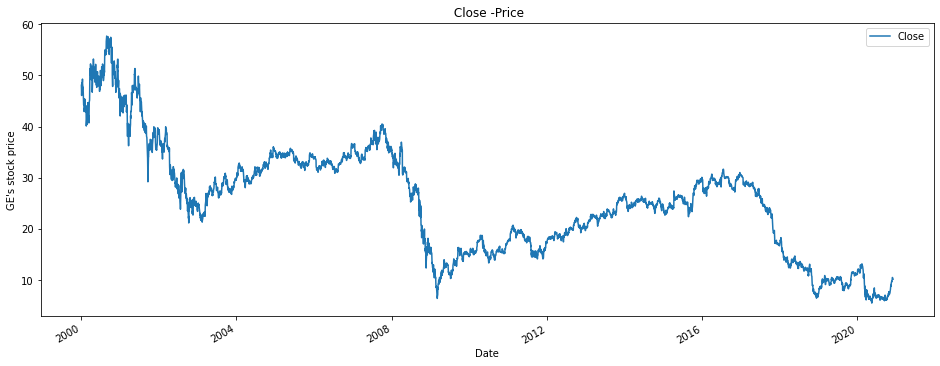

In [19]:
plt.figure(figsize=(16,6))

df["Close"].plot(label="Close")
#df["Open"].plot(label="Open")

plt.title(" Close -Price")

plt.ylabel("GE's stock price")
plt.legend();

Train , Test Data 

In [20]:
df =df.filter(["Close"])

In [25]:
train, test = df[df.index <= '2012-12-31'], df[df.index > '2012-12-31']

In [30]:
train.shape, test.shape

((3269, 1), (1994, 1))

Normalization

In [31]:
scale = MinMaxScaler()

train_data = scale.fit_transform(train)
train_data[:5]

array([[0.81252346],
       [0.77502815],
       [0.77346585],
       [0.78547608],
       [0.82072556]])

In [32]:
train_data.shape

(3269, 1)

In [33]:
test_data = scale.fit_transform(test)
test_data[:5]

array([[0.57421636],
       [0.56539949],
       [0.56907318],
       [0.56650162],
       [0.55805203]])

In [34]:
test_data.shape

(1994, 1)

LSTM form

In [37]:
X_train = []
y_train = []

timesteps =30

for i in range(timesteps, train_data.shape[0]):
    X_train.append(train_data[i-timesteps:i])
    y_train.append(train_data[i, 0])

In [38]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((3239, 30, 1), (3239,))

In [39]:
X_test = []
y_test = []

timesteps =30

for i in range(timesteps, test_data.shape[0]):
    X_test.append(test_data[i-timesteps:i])
    y_test.append(test_data[i, 0])

In [40]:
X_test, y_test = np.array(X_test), np.array(y_test)

X_test.shape , y_test.shape

((1964, 30, 1), (1964,))

Early stopping

In [43]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=2,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta=0.0001)


callbacks = [earlystop,reduce_lr]

LSTM Model

In [44]:
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(60, activation='relu', return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(LSTM(120, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))


model.compile( loss = "mean_squared_error", optimizer = "adam")

In [45]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 120)           58560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                43440     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 120)           86880     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             121       
Total params: 218,041
Trainable params: 218,041
Non-trainable params: 0
__________________________________________________

In [46]:
history = model.fit(X_train, y_train, epochs=25, batch_size=20,shuffle = True,
                    callbacks=callbacks , validation_split=0.3)

Epoch 1/25
114/114 [==============================] - 15s 95ms/step - loss: 0.1042 - val_loss: 0.0095
Epoch 2/25
114/114 [==============================] - 10s 89ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 3/25
114/114 [==============================] - 10s 90ms/step - loss: 0.0014 - val_loss: 9.8129e-04
Epoch 4/25
114/114 [==============================] - 10s 90ms/step - loss: 0.0013 - val_loss: 6.2103e-04
Epoch 5/25
114/114 [==============================] - 10s 90ms/step - loss: 9.8597e-04 - val_loss: 5.5921e-04
Epoch 6/25
114/114 [==============================] - 10s 90ms/step - loss: 8.7123e-04 - val_loss: 7.7787e-04

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/25
114/114 [==============================] - 10s 90ms/step - loss: 7.1464e-04 - val_loss: 7.1067e-04
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


Prediction

In [51]:
y_pred = model.predict(X_test)

In [53]:
y_pred.shape

(1964, 30, 1)

Accuracy

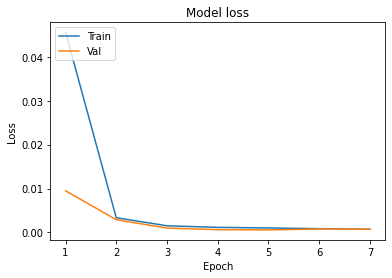

In [48]:
def plot_learningCurve(history):
  # Plot training & validation accuracy values
    epoch_range = range(1, len(history.epoch) +1)
    # plt.plot(epoch_range, history.history['accuracy'])
    # plt.plot(epoch_range, history.history['val_accuracy'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Val'], loc='upper left')
    # plt.show()

  # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()


plot_learningCurve(history)

Train data

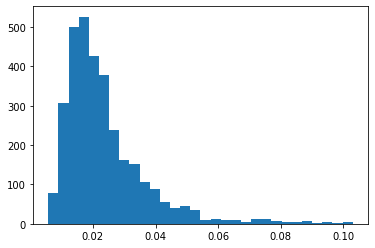

In [71]:
trainPredict = model.predict(X_train)
trainMAE = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=30,label="MAE");

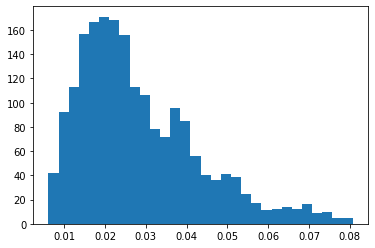

In [57]:
testPredict = model.predict(X_test)
testMAE = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=30);

Anomaly detection

In [83]:
max_trainMAE = 0.045  #or Define 90% value of max as threshold.

In [76]:
testMAE.shape

(1964, 1)

In [78]:
anomaly_df = pd.DataFrame(test[timesteps:])
anomaly_df.shape

(1964, 1)

In [84]:
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']

In [85]:
anomaly_df.head()

,Close,testMAE,max_trainMAE,anomaly
Date,,,,
2013-02-14,22.509615,0.039238,0.045,False
2013-02-15,22.394230,0.040410,0.045,False
2013-02-19,22.836538,0.040843,0.045,False
2013-02-20,22.509615,0.042113,0.045,False
2013-02-21,22.365385,0.042462,0.045,False


In [92]:
# anomaly_df['Close'] = test[timesteps:]['Close']

# anomaly_df.head()

Plot testMAE vs max_trainMAE

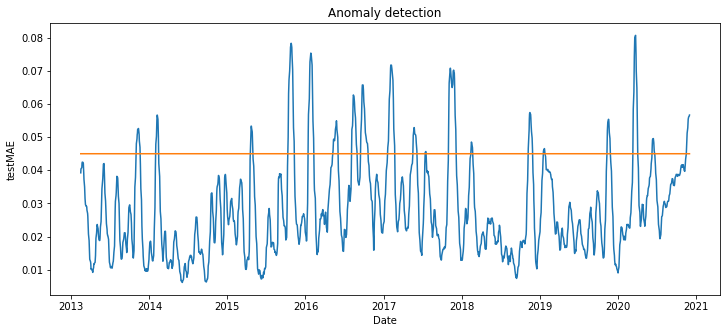

In [98]:
plt.figure(figsize=(12,5))

sns.lineplot(x=anomaly_df.index, y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAE']);

plt.title('Anomaly detection');

Plot anomalies

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [114]:
anomaly_y =scale.inverse_transform(np.array(anomaly_df['Close']).reshape(-1, 1))

anomaly_y = anomaly_y.reshape( -1)

anomalies_y =scale.inverse_transform(np.array(anomalies['Close']).reshape(-1, 1))

anomalies_y = anomalies_y.reshape( -1)

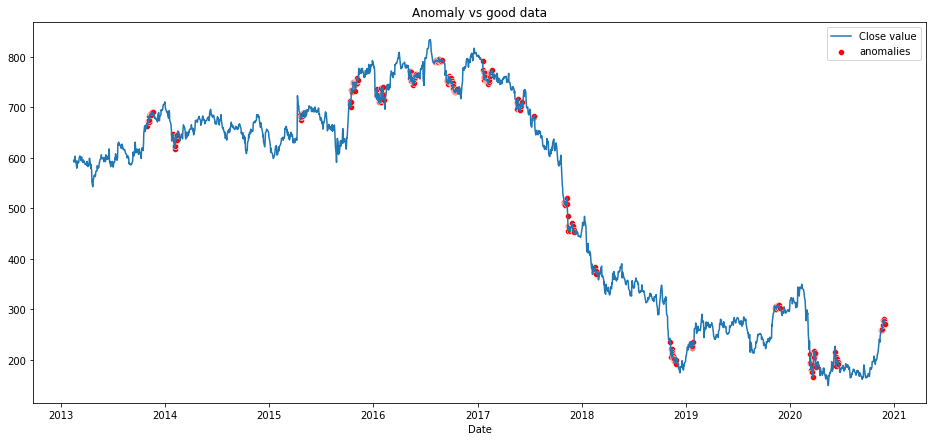

In [127]:
#Plot anomalies
plt.figure(figsize=(16,7))

sns.lineplot(x=anomaly_df.index, y=anomaly_y, label="Close value")
sns.scatterplot(x=anomalies.index, y=anomalies_y, label="anomalies" ,color='r')

plt.title('Anomaly vs good data'); 